# Machine learnig : from the data to the predictions

In [1]:
#%% Importations

!pip install xlrd

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import imageio
import time
import random

from joblib import dump, load                #To save and load our trained machine learning models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from math import atan, sqrt, pi, cos, sin

In [2]:
#%% Reading the training data

train_filename = "demo_ship_segmentations.xls"
training_data_path = ""
training_images_path = ""         

training_data = pd.read_excel(training_data_path+train_filename)         #reading the xls file 
print("Shaoe of the excel :",training_data.shape)                            
print("The first lines :")
print(training_data.head())                                              



Shaoe of the excel : (20, 2)
The first lines :
         ImageId                                      EncodedPixels
0  000c34352.jpg                                                NaN
1  00a52cd2a.jpg  377223 1 377990 4 378758 5 379525 8 380292 10 ...
2  00a9e2ec9.jpg  90666 2 91434 6 92202 8 92969 9 93737 9 94505 ...
3  00abc623a.jpg  308744 1 309511 4 310279 6 311046 9 311814 11 ...
4  00abc623a.jpg  195657 2 196425 5 197192 9 197960 12 198728 15...


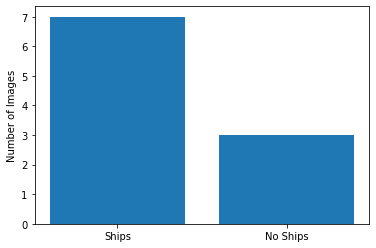

In [3]:
#%% Ships / No Ships repartition

plt.bar(['Ships', 'No Ships'], 
    [len(training_data[~training_data.EncodedPixels.isna()].ImageId.unique()),
    len(training_data[training_data.EncodedPixels.isna()].ImageId.unique())]);
plt.ylabel('Number of Images');
plt.show()



### Binary image generation from the training data


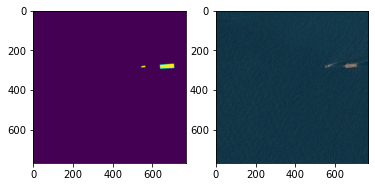

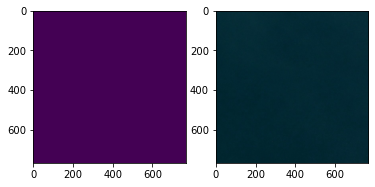

In [4]:
#%% Binary image generation from the training data


def Binary_Image(image_name, data, filename, data_path):                                             #Input = image name + data name + filname + path, output = binary image (boat pixels = 1, no boat pixels = 0) using the 'EncodedPixels' data
    bimage = np.zeros((768,768))
    data2 = pd.read_excel(data_path+filename, index_col='ImageId')              #reading the csv file, using image names as index
    if type(data2['EncodedPixels'][image_name]) == float : return bimage        #no boat on the image, 
    data_image = data[data['ImageId']==image_name]                              #data_image group the data (rows) linked to the same image name 
    for index in data_image.index :                                             #for loop on the data from data_image to concider each boat (one line ~ one boat)
        rle = [int(i) for i in data_image['EncodedPixels'][index].split()]      #turn the encoded info in a list of split integers
        starts = list(rle[0:-1:2])                                              #list of the starts
        lengths = list(rle[1::2])                                               #list of the lengths
        n = len(starts)                                         
        for k in range(n):
            bimage[starts[k] % 768 : starts[k] % 768 + lengths[k] , starts[k] // 768  ] = 1       #The coordinate of the start k are : (starts[k] % 768, starts[k] // 768)
    return bimage

#Examples

plt.figure("1")
plt.subplot(1,2,1)
plt.imshow(Binary_Image('0ae37aa28.jpg', training_data, train_filename, training_data_path))       #2 boats
plt.subplot(1,2,2)
plt.imshow(img.imread("0ae37aa28.jpg"))


plt.figure("2")

plt.subplot(1,2,1)
plt.imshow(Binary_Image('0ae271a03.jpg', training_data, train_filename, training_data_path))       #no boat
plt.subplot(1,2,2)
plt.imshow(img.imread("0ae271a03.jpg"))

plt.figure("3")

plt.subplot(1,2,1)
plt.imshow(Binary_Image('0b8ce2b47.jpg', training_data, train_filename, training_data_path))       #8 boats
plt.subplot(1,2,2)
plt.imshow(img.imread("0b8ce2b47.jpg"))


plt.figure("4")

plt.subplot(1,2,1)
plt.imshow(Binary_Image('0ae49bc36.jpg', training_data, train_filename, training_data_path))       #2 boats but only one according to the airbus training 
plt.subplot(1,2,2)
plt.imshow(img.imread("0ae49bc36.jpg"))


### First methode to formatting  X and y 

The goal is to formate the features and label data so they can be used by the scikit learn modules
X is an array, each column is associated to R, G or B values of the pixels of the dataset images
The elements of y are 0 or 1
Number of lignes = total number of pixels
The images dimension is 768*768

The probleme of this methode is that X and y requier lots of memory (hundreds of GiB for more than 10 000 images)
Plus, most of the pixel are no-boat pixels (about 99%) so the model learning won't be balanced
Plus, the training time is very high, so it is impossible to optimize the hyperparameters



In [5]:
#%% First methode to format X and y (not the one we will use)

training_Image_list = list(training_data.ImageId.unique())           #List of the dataset image names
data_size = len(training_Image_list)

def get_X(Image_list, images_path):
    c = 0
    data_size = len(Image_list)                        #number of image considered, should be len(Image_list) but the algorithm require too much space
    X = np.zeros((data_size*768*768,3))                #features
    for k in range(data_size) :
        image_name = Image_list[k]
        f = imageio.imread(images_path+image_name)     #read image, f is like (ligne,column,color)                        
        for j in range(768) :
            for i in range(768) :
                X[c+768*j+i,0], X[c+768*j+i,1], X[c+768*j+i,2] = f[i,j,0], f[i,j,1], f[i,j,2]       #concatenation for red values in the first X column
        c = c + 768**2
    return X
        

def get_y(data, data_path, filename ):
    c = 0
    Image_list = list(data.ImageId.unique())           #List of the dataset image names
    data_size = len(Image_list)                        #number of image considered, should be len(Image_list) but the algorithm require too much space
    y = np.zeros((data_size*768*768,))                 #labels
    for k in range(data_size) :
        image_name = Image_list[k]
        bimage = Binary_Image(image_name, data, filename, data_path)                        
        for j in range(768) :
            for i in range(768) :
                y[c+768*j+i] = bimage[i,j]
        c = c + 768**2
    return y


def get_X_and_y(images_path, data, data_path, filename ):
    c = 0
    Image_list = list(data.ImageId.unique())
    data_size = len(Image_list)                        
    X = np.zeros((data_size*768*768,3))                
    y = np.zeros((data_size*768*768,))                 
    for k in range(data_size) :
        image_name = Image_list[k]
        f = imageio.imread(images_path+image_name)                     
        bimage = Binary_Image(image_name, data, filename, data_path)                        
        for j in range(768) :
            for i in range(768) :
                X[c+768*j+i,0], X[c+768*j+i,1], X[c+768*j+i,2] = f[i,j,0], f[i,j,1], f[i,j,2]                   
                y[c+768*j+i] = bimage[i,j]
        c = c + 768**2
    return X , y

#t1 = time.process_time()
# print("Calculating X...")
# X = get_X(training_Image_list, training_images_path)
# print("--> Done")
# print("Calculating y...")
# y = get_y(training_data, training_data_path, train_filename )
# print("--> Done")
# print("Calculted in : ",time.process_time()-t1)

print("Calculating X and y...")
t1 = time.process_time()
X , y = get_X_and_y( training_images_path, training_data, training_data_path, train_filename)
print("--> Done")
print("Calculted in : ",time.process_time()-t1,"s")
print("X :",X)
print("y :",y)
print("Proportion of boats on the images is", 100*sum(y)/(data_size*768*768),"%")


Calculating X and y...
--> Done
Calculted in :  7.868832422 s
X : [[177. 172. 153.]
 [ 96.  91.  72.]
 [102.  97.  78.]
 ...
 [ 10.  40.  51.]
 [ 12.  42.  53.]
 [ 14.  44.  55.]]
y : [0. 0. 0. ... 0. 0. 0.]
Proportion of boats on the images is 0.8813985188802084 %


### Alternative soltion to format the features and labels

For a better model, lighter data usage and shorter training time, we will use train data with a 50-50 propotion by randomly ignore non-boat pixels

In [6]:
# Proportion p of boat-pixels in the training data set

def boat_probability(data, data_path, filename):
    c = 0                                              
    Image_list = list(data.ImageId.unique())           
    data_size = len(Image_list)                        
    for k in range(data_size) :
        image_name = Image_list[k]
        bimage = Binary_Image(image_name, data, filename, data_path)                        
        for j in range(768) :
            for i in range(768) :
                c = c+bimage[i,j]                      
    return c/(data_size*768*768)


# Formatting  X and y

def get_X_and_y_light(images_path, data, data_path, filename, p ):
    Image_list = list(data.ImageId.unique())
    data_size = len(Image_list)                                                      #number of image considered, should be len(Image_list) but the algorithm require too much space
    R, G, B, y = [],[],[],[]                                                         #a list for each color, a list for the labels
    for k in range(data_size) :
        image_name = Image_list[k]
        f = imageio.imread(images_path+image_name)                                   #read image, f is like (ligne,column,color)    
        bimage = Binary_Image(image_name, data, filename, data_path)    
        for j in range(768) :
            for i in range(768) :
                b = bimage[i,j]
                if (b == 1 or (b == 0 and (random.random()<p)) ):                    #if this is a boat-pixel we consider it, if this is a no-boat pixel, the probability that it will be considered is equal to p (the proportion of boat-pixels)
                    R.append(f[i,j,0])                                               #We use lists because they can dynamically expend, arrays cannot so it would takes very long too use np.append on big data set (the array is copied every loop)
                    G.append(f[i,j,1])
                    B.append(f[i,j,2])
                    y.append(b)
    return np.column_stack((R,G,B)) , np.array(y)                                    #stack of red, green and blue --> features, y --> labels


t1 = time.process_time()
print("Calculating p...")
p = boat_probability(training_data, training_data_path, train_filename)
print("--> Done")
print("Proportion of boats on the images", 100*p,"%")

print("Calculing X and y (light version)...")
X , y = get_X_and_y_light(training_images_path, training_data, training_data_path, train_filename, p)
print("--> Done")
print("Calculted in : ",time.process_time()-t1,"s")
print("X :",X)
print("y :",y)
print("Proportion of boats in the features : ", 100*sum(y)/(np.shape(y)[0]),"%")

Calculating p...
--> Done
Proportion of boats on the images 0.8813985188802084 %
Calculing X and y (light version)...
--> Done
Calculted in :  4.6141962979999995 s
X : [[140 137 120]
 [253 250 231]
 [  0  32  25]
 ...
 [ 15  42  53]
 [ 12  39  50]
 [  9  35  48]]
y : [0. 0. 0. ... 0. 0. 0.]
Proportion of boats in the features :  50.28242576651514 %


### The machine learning model, using scikit-learn

We will use the scikit-learn library and its models.
To evaluate the model preformance, we split the data set : the train set and the test set. So we can evaluate the model on unseen data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

To have a good model, we must normalize the data through a tranformer (we will use the MinMax normalisation) before using them in the estimator.
To make it simple, we use "pipline" so the model normalize the data before using the estimator :


In [8]:
#The model chosen
model1 = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(n_estimators=100 ,verbose=3))
model_name = 'model_gradientboostingclassifier_demo.joblib'   #must have '.joblib' as extension

#Training 
t1 = time.process_time()
model1.fit(X_train, y_train)
print("Model trained in",time.process_time()-t1)

dump(model1, model_name )  #Save the model
print("Model saved.")

a=model1.score(X_test,y_test)
print("Its score on the test set is :",a)

      Iter       Train Loss   Remaining Time 
         1           1.2756            5.68s
         2           1.1845            5.18s
         3           1.1079            4.74s
         4           1.0440            4.39s
         5           0.9883            4.15s
         6           0.9416            3.99s
         7           0.8997            3.86s
         8           0.8638            3.87s
         9           0.8326            4.27s
        10           0.8050            4.33s
        11           0.7805            4.29s
        12           0.7566            4.22s
        13           0.7356            4.09s
        14           0.7177            3.98s
        15           0.7022            3.87s
        16           0.6880            3.77s
        17           0.6745            3.68s
        18           0.6639            3.59s
        19           0.6529            3.53s
        20           0.6431            3.46s
        21           0.6347            3.39s
        2

To get the best precision and the balance between over-fitting and under-fitting, we can tune the hyperparameters of the model. To do that, we use cross validation.
In scikit learn we can use cross_val_score to part the set and evaluate the score on each.
We can also use validation_curve to see more easily which parameter is the best, but only one a the time.
To test combinaisons of hyperparameters, we use GridSearchCV.
Also, the learning curve can allow us to know if the model would get better with a more data.

Have a look at the complet Python script to see how you can use GridSearchCV, validation_curve and learning_curve.
You can find example of validation and learning curves for KNN and the gradient boosting classifier in our report.
Once your model is optimised and trained. You can see how it performes on large a test set of unseen images. But first you need to build an excel file corresponding to this data set. To do that, you can use our full code.

Notice that the model only consider the color values of the pixels (not the geometry) so we expect that our model won't be really accurate. But you can hop for 60% to 70% of accuracy on the pixels for "classic" images where you are looking for boats. If you are satisfied, you can start making predictions :

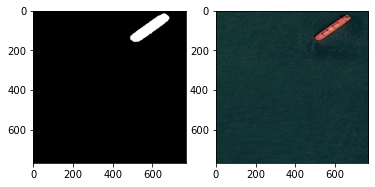

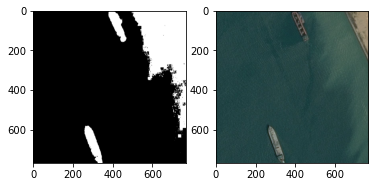

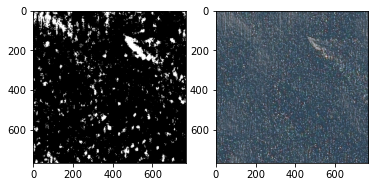

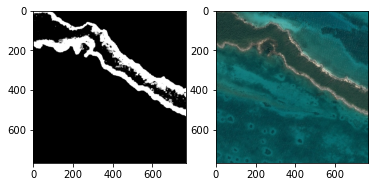

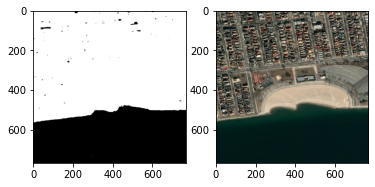

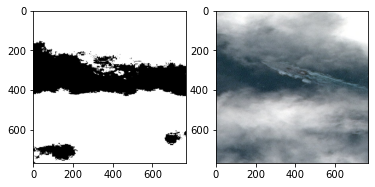

In [9]:
#%% The prediction as binary images

#load model
model_path = ""
model_name =  'model_SGDClassifier_random_1000.joblib' 
model = load(model_path+model_name)


def prediction(model, image_path, image_name):              #from an image, return a binary image of the model prediction
    X = np.zeros((768*768,3))
    f = imageio.imread(image_path+image_name)                                    
    for j in range(768) :
        for i in range(768) :
            X[768*j+i,0] = f[i,j,0]                         #concatenation for red values in the first X column
            X[768*j+i,1] = f[i,j,1]
            X[768*j+i,2] = f[i,j,2]
    y = model.predict(X)
    predicted_image = np.zeros((768, 768, 3))
    for i in range(768*768):
        color = (y[i]*255)
        predicted_image[ i%768, i//768, :3] = [color, color, color]
    return predicted_image.astype(np.uint8)

a = img.imread("00a52cd2a.jpg")
b = img.imread("00abc623a.jpg")
c = img.imread("00031f145.jpg")
d = img.imread("00b846e38.jpg")
e = img.imread("000c34352.jpg")
f = img.imread("1e60a9a0a.jpg")

a_ml = prediction(model,"","00a52cd2a.jpg")
b_ml = prediction(model,"","00abc623a.jpg")
c_ml = prediction(model,"","00031f145.jpg")
d_ml = prediction(model,"","00b846e38.jpg")
e_ml = prediction(model,"","000c34352.jpg")
f_ml = prediction(model,"","1e60a9a0a.jpg")

plt.subplot(1,2,1)
plt.imshow(a_ml)
plt.subplot(1,2,2)
plt.imshow(a)
plt.show()

plt.subplot(1,2,1)
plt.imshow(b_ml)
plt.subplot(1,2,2)
plt.imshow(b)
plt.show()

plt.subplot(1,2,1)
plt.imshow(c_ml)
plt.subplot(1,2,2)
plt.imshow(c)
plt.show()

plt.subplot(1,2,1)
plt.imshow(d_ml)
plt.subplot(1,2,2)
plt.imshow(d)
plt.show()

plt.subplot(1,2,1)
plt.imshow(e_ml)
plt.subplot(1,2,2)
plt.imshow(e)
plt.show()

plt.subplot(1,2,1)
plt.imshow(f_ml)
plt.subplot(1,2,2)
plt.imshow(f)
plt.show()

### Post-Processing : denoising

As we can see, the machine learning method often get confused with littorals, clouds and foam and consider them as ship. That is why a post-treatment is needed, considering the forms and not only the color, it's the denoising.
The first step is to encode the binary image in order to separates the different groups of pixels of the image and put the datas in the right form for the post-processing. During this encoding step, a first denoising is applied which only consists in considering only the big enough amount of pixels, erasing the others.


In [10]:
#%% For plotting the images with different colors for the ships

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255), (255, 255, 255),
              (130, 0, 0), (0, 130, 0), (0, 0, 130), (130, 130, 0), (130, 0, 130), (0, 130, 130), (130, 130, 130)]
def image(boats):
    '''
        Function that return a "binary" image (different colors for each ship) from a list of boats (= list of sections),
    result of the encode_image function. This function was especially created in order to test and show different results
    and functions.
    '''
    im = np.zeros([768, 768, 3]) # Image creation
    i = 0 # To change the color when changing the boat
    
    for boat in boats:
        for s in boat: # Each sections of the boat is colorated
            im[s.start_pos[0], s.start_pos[1]:s.start_pos[1] + s.lenght, 0:3] = colors[i%len(colors)] # Coloring pixels
        
        i += 1
        
    return im.astype(np.uint8)

#%% First encoding

def areLinked(s1, s2):
    '''
        Function that tests if 2 sections are linked
    '''
    pos1, pos2 = s1.start_pos[1], s2.start_pos[1] # Position of the start of the section
    ext1, ext2 = pos1 + s1.lenght, pos2 + s2.lenght # Position of the end of the section
    
    # Case one extremity is linked to the upper section, or the upper section is completly linked to the lower section
    if (pos1 >= pos2 and pos1 <= ext2) or (ext1 >= pos2 and ext1 <= ext2) or (pos1 < pos2 and ext1 > ext2):
        return True # The 2 sections are effectively linked
    return False


def formBoat(s, boat):
    '''
        Recursive function that put all the linked sections in a list (boat) which represents a ship.
        When there is too much noise, there are problems of recursive depht with this function, that's why there's a
    try-except stuff in encode_image.
    '''
    boat.append(s)
    s.isBoated = True
    
    for sec in s.sections:
        if not sec.isBoated:
            formBoat(sec, boat) # Recursive
   
    
class Section:
    '''
        This class represent a data as considered in the Airbus excels : a start_pos position is the first pixel of the
    section, and lenght is the lenght of section. For exemple : start_pos = (12, 24) and lenght = 5 would mean that 
    (12, 24), (12, 25), (12, 26), (12, 27) and (12, 28) are "ship" pixels.
    '''
    instances = [] # All Section object created
    def __init__(self, start_pos, lenght):
        self.start_pos = start_pos
        self.lenght = lenght
        self.sections = [] # The sections linked to this one
        self.isBoated = False # When generating the boats, in order to know if this sections had already been treated 
   
        
def encode_image(bimage, minimum_size = 100):
    '''
        This function encodes the image bimage by differentiating the different boats on the binary image bimage (also reducing the noise at
    the same time).
        minimum_size corresponds to the minimum amount of linked pixels that are requires to consider this as a ship
    (it's for unoising).
    '''
    sections = [[] for i in range(768)] # The sections of each line
    
    # Locating the different continuous sections
    start = False
    start_pos = (0, 0)
    c = 1
    for i in range(768):
        for j in range(768):
            if bimage[i, j, 0] == 255: # Ship pixel
                if not start: # We havn't started a section
                    c = 1 # There's only 1 pixel for now...
                    start_pos = (i, j) # ...at the start position
                    start = True # Now, we are in a section
                elif i == start_pos[0]: # We're still on the same line
                    c += 1 # The lenght of the section is just increasing
                else: # We've passed to the next line,
                    s = Section(start_pos, c) # so we end the section
                    sections[start_pos[0]].append(s) # to the right line
                    Section.instances.append(s) 
                    c = 1 # and start a new one
                    start_pos = (i, j)
                    
            elif start: # The section is over (not a ship pixel)
                s = Section(start_pos, c)
                sections[start_pos[0]].append(s)
                Section.instances.append(s) 
                start = False # We're not in a section anymore
                
    # Linking the different sections
    for i in range(1, len(sections)):
        # We only look at two adjacent lines
        for s1 in sections[i]:
            for s2 in sections[i-1]:
                if areLinked(s1, s2):
                    s1.sections.append(s2) # We link both the sections
                    s2.sections.append(s1)
                    
    # Forming the boats
    boats = []
    for s in Section.instances:
        if not s.isBoated: # If the section isn't already in a ship
            boat = []
            # The try...except stuff is only here to dodge the "maximum recursive depth reached" that occurs when using
            # this algorithm on a very noisy image (that isn't supposed to happen...)
            try:
                formBoat(s, boat) # It completes the boat list with all the sections linked to s (directly or not)
            except:
                pass
            
            # Number of ship pixels in this group (boat)
            ships_number = 0
            for sec in boat:
                ships_number += sec.lenght
                
            if not ships_number < minimum_size: # If the amount of ship isn't too low (= noise)
                boats.append(boat)  
            
    return boats

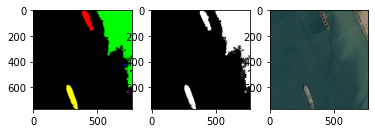

In [11]:
#%% Plotting

a_boats = encode_image(a_ml)
a_e = image(a_boats)
b_boats = encode_image(b_ml)
b_e = image(b_boats)
c_boats = encode_image(c_ml)
c_e = image(c_boats)
d_boats = encode_image(d_ml)
d_e = image(d_boats)
e_boats = encode_image(e_ml)
e_e = image(e_boats)
f_boats = encode_image(f_ml)
f_e = image(f_boats)

plt.subplot(1,3,1)
plt.imshow(a_e)
plt.subplot(1,3,2)
plt.imshow(a_ml)
plt.subplot(1,3,3)
plt.imshow(a)
plt.show()

plt.subplot(1,3,1)
plt.imshow(b_e)
plt.subplot(1,3,2)
plt.imshow(b_ml)
plt.subplot(1,3,3)
plt.imshow(b)
plt.show()

plt.subplot(1,3,1)
plt.imshow(c_e)
plt.subplot(1,3,2)
plt.imshow(c_ml)
plt.subplot(1,3,3)
plt.imshow(c)
plt.show()

plt.subplot(1,3,1)
plt.imshow(d_e)
plt.subplot(1,3,2)
plt.imshow(d_ml)
plt.subplot(1,3,3)
plt.imshow(d)
plt.show()

plt.subplot(1,3,1)
plt.imshow(e_e)
plt.subplot(1,3,2)
plt.imshow(e_ml)
plt.subplot(1,3,3)
plt.imshow(e)
plt.show()

plt.subplot(1,3,1)
plt.imshow(f_e)
plt.subplot(1,3,2)
plt.imshow(f_ml)
plt.subplot(1,3,3)
plt.imshow(f)
plt.show()

We're now going to apply different filters to these images in order to delete the littorals and clouds from the images. In order to do this, we've implemented 3 different methods, all based on the form of the group of pixels.

### Density filter
This first filter, the easiest of the 3, only consists in calculating the average density of the boat image (i.e. the average number of pixels representing a ship in the neighborhood of each ship pixel) and to compare this value to a chosen threshold.

In [12]:
#%% Utilitary tools

def del_boats(boats, to_del):
    '''
        Function that deletes elements of the list boats according to the number of cases in to_del list.
        It returns a modified copy of the boats list
    '''
    count = 0 # We consider that the size of boats_copy get smaller at each suppression
    boats_copy = boats[:]
    for i in to_del: # to_del is composed of the cases to delete in boats list (the numbers)
        boats_copy.pop(i - count)
        count += 1
        
    return boats_copy


def boats_box(boats):
    '''
        This function returns the boxs that encadrates the different boats of the boats list.
        The boxs list that is returned is a tuple considering the position, the width and the height of the box, as required
    by the matplotlib.patches.Rectangle class.
    '''
    boxs = []
    for boat in boats: # For each boat, we create a box
        x = [] ; y = [] # The positions of the pixels
        for s in boat: # For each section (see class Section in Encoding.py), we update the pixels location
            x += [s.start_pos[0]] # The x value doesn't change in a section
            y += [s.start_pos[1], s.start_pos[1] + s.lenght] # We only consider the minimum and maximum values (faster)
        
        boxs.append(((min(y), min(x)), max(x) - min(x) + 1, max(y) - min(y) + 1)) # Corresponds to the matplotlib condtions for drawing rectangles
        
    return boxs


def boats_as_image(boats, boxs):
    '''
        Thanks to this function, we can transform the boats list (where each boat in a list of sections) to a list far easier
    to work on (where each boat is a binary image of the size of his box).
    '''
    boats_images = [] # The new list of image like boats
    for i in range(len(boats)):
        boat_image = np.zeros([boxs[i][1], boxs[i][2], 1]) # Image creation (can be shown thanks to imshow image)
        ymin, xmin = boxs[i][0] # The origin of the box
        for s in boats[i]: # For each section of the boat, we fullfil the corresponding image
            xs, ys = s.start_pos[0] - xmin, s.start_pos[1] - ymin # Change of coordinate system position
            for y in range(ys, ys + s.lenght): # The y value changes
                boat_image[xs, y, 0] = 255 # The xs value is constant in a section
        boats_images.append(boat_image)
    
    return boats_images

In [13]:
def density_filter(boats, boats_images, min_value = 5):
    '''
        A first method to sort the different "ships" located by the encode_image function. 
        This method works on the density of the different pile of pixels, the most dense one (that are superiors to a given 
    limit) are supposed to be ships. Indeed, the ships are generally denser than foam, clouds and littorals...
        Parameters :
            - boats : the list each amounts of pixels on the image, each one are lists of Sections objects (see Encoding.py)
            - boats_images : the same boats under image form (result of the boats_as_image function)
            - min_value : the minimal number of average sticked pixels to consider the amount of pixels as a ship
    '''
    to_del = []
    for i in range(len(boats_images)): # As always, we study each supposed boat
        boat = boats_images[i]
        average_density = 0 ; count = 0 # We calculate the average density of the pile of pixels
        size = boat.shape
        
        # We only consider the center of the image (easier and the image is big enough to consider that the bordures have little impact)
        for x in range(1, size[0] - 1):
            for y in range(1, size[1] - 1):
                if boat[x, y, 0] == 255:
                    average_density += (boat[x+1, y, 0] + boat[x+1, y+1, 0] + boat[x, y+1, 0] + boat[x, y-1, 0] + boat[x-1, y-1, 0] + boat[x-1, y, 0]) / 255
                    count += 1
                    
        average_density /= count
        if average_density < min_value: # The condition for considering that the "boat" is not really a ship
            to_del.append(i) # List of the indices of the cases that have to be deleted
        
    return del_boats(boats, to_del) # We delete these cases and return the new list

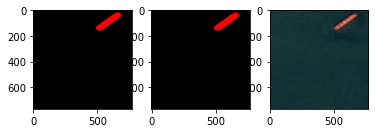

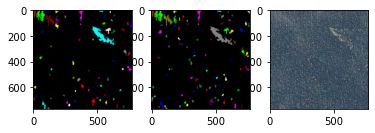

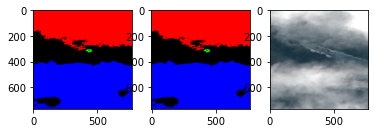

In [14]:
a_boxs = boats_box(a_boats)
a_boats_images = boats_as_image(a_boats, a_boxs)
a_boats = density_filter(a_boats, a_boats_images)
a_density = image(a_boats)

c_boxs = boats_box(c_boats)
c_boats_images = boats_as_image(c_boats, c_boxs)
c_boats = density_filter(c_boats, c_boats_images)
c_density = image(c_boats)

f_boxs = boats_box(f_boats)
f_boats_images = boats_as_image(f_boats, f_boxs)
f_boats = density_filter(f_boats, f_boats_images)
f_density = image(f_boats)


plt.subplot(1,3,1)
plt.imshow(a_density)
plt.subplot(1,3,2)
plt.imshow(a_e)
plt.subplot(1,3,3)
plt.imshow(a)
plt.show()

plt.subplot(1,3,1)
plt.imshow(c_density)
plt.subplot(1,3,2)
plt.imshow(c_e)
plt.subplot(1,3,3)
plt.imshow(c)
plt.show()

plt.subplot(1,3,1)
plt.imshow(f_density)
plt.subplot(1,3,2)
plt.imshow(f_e)
plt.subplot(1,3,3)
plt.imshow(f)
plt.show()

We only show 3 examples as the density filter is only "efficient" on one of these 6...
On the first, we can see that the filter isn't erasing the ship, that's a good start.
On the second one, we can see that when there are a lot of fragment (generally due tu foam), the density filter allows the suppression of some fragments.
On the last one, we can see that when fragment are dense, the density filter naturally doesn't work anymore.
This filter is more efficient when we take the average_color method for generating the binary image.

### Symetry filter
The most complicate to implement but also the less efficient of the 3 filters... It may be improved quite a lot I think, by testing different parameters or by modifying directly the code. The idea is to work on the symetries, important caracteristics of ships, we consider 4 directions for the symetries (horizontal, vertical, diagonal ascendent and diagonal descendent) and each direction as 3 axis displaced in order to take in acount the fact that ships aren't always aligned on the symetry axis.

In [15]:
def symetry_filter(boats, boats_images, adm_error = 0.3, dec = 0.2):
    '''
        This second methods works on the symetries to find which amount of pixels are ships and which are not. Indeed, there
    are always symetries among ships. It tries on four different orientation of symetries (horizontal, vertical, diagonal
    descendent and diagonal ascendent), and on three position of the axis too.
        But, truth be told, it doesn't works very well... Generally the density filter is more efficient.
        Parameters :
            - boats : the list each amounts of pixels on the image, each one are lists of Sections objects (see Encoding.py)
            - boats_images : the same boats under image form (result of the boats_as_image function)
            - adm_error : admissible error on the symetries for considering an amount of pixels as a ship
            - dec : relative distance between the displaced axis
        Returns the newly sorted boats list (after a passage to the del_boats function)
    '''
    to_del = []
    for i in range(len(boats_images)):
        boat = boats_images[i]
        # errors = [Horizontal, Vertical, Diagonal1, Diagonal2] and [centered, displaced up/right, displaced down/left]
        errors = [[0, 0, 0] for j in range(4)] 
        count = 0 # For computing the average errors
        size = boat.shape
        
        # Positions of each angle of the box
        xA, yA = 0, size[1]-1 ; xB, yB = size[0]-1, size[1]-1 ; xC, yC = size[0]-1, 0 ; xD, yD = 0, 0
        xHo = (xA + xC + 1)/2 # The middle horizontal value (axis y = xHo as symetry axis)
        yVe = (yA + yC + 1)/2 # The middle vertical value
        a1, a2 = (yB - yD) / (xB - xD), (yC - yA) / (xC - xA) # Diagonal slopes (1 : descendent, 2 : ascendent)
        teta1, teta2 = atan(a1), pi/2 - atan(a2) # Angles forming by these diagonals with the x axis
        diag_lenght = sqrt(size[0]**2 + size[1]**2) # Lenght of the diagonal
        
        for x in range(size[0]):
            for y in range(size[1]):    
                # For each ship pixel, we check if his symetric by all the different axis is a ship pixel too, and we
                # increase the error in consequence
                if boat[x, y, 0] == 255:
                    ##### Horizontal symetries #####
                    # Centered axis
                    dHo = abs(x - xHo) # Distance to the axis (y = xHo)
                    sign = -1 # To reduce the quantity of lines : -1 if the point we study is to the right of the axis, 
                    # 1 otherwise
                    if x < xHo:
                        sign = 1
                    if boat[x + sign*int(2*dHo) - sign, y, 0] == 0: # If the symetric isn't a ship,
                        errors[0][0] += 1 # we increase the error linked to this symetry
                    
                    # Displaced axis
                    for eps in [-1, 1]: # -1 : axis displaced to the left, 1 : to the right
                        xHo_dis = (1 + eps*dec)*xHo # New position of the axis (y = xHo_bis)
                        dHo_dis = abs(x - xHo_dis) # Distance
                        sign = -1
                        if x < xHo_dis:
                            sign = 1
                        try: # We only consider the pixels that exist...
                            pos = x + sign*int(2*dHo_dis) - sign
                            if pos >= 0: # We want it positive because we don't want to "take the list in the other way"
                                if boat[pos, y, 0] == 0: # We check the symetric
                                    errors[0][eps] += 1
                        except:
                            pass
                      
                    ##### Vertical symetries #####
                    # It works exactly the same way as the horizontal symetries but with y rather than x
                    # Centered one
                    dVe = abs(y - yVe)
                    sign = -1
                    if y < yVe:  
                        sign = 1
                    if boat[x, y + sign*int(2*dVe) - sign, 0] == 0:
                        errors[1][0] += 1
                        
                    # Displaced ones
                    for eps in [-1, 1]:
                        yVe_dis = (1 + eps*dec)*yVe
                        dVe_dis = abs(y - yVe_dis)
                        sign = -1
                        if y < yVe_dis:
                            sign = 1
                        try:
                            pos = y + sign*int(2*dVe_dis) - sign
                            if pos >= 0:
                                if boat[x, pos, 0] == 0:
                                    errors[1][eps] += 1
                        except:
                            pass
                            
                    ##### Diagonal descendent symetries #####
                    # Centered one
                    # We change of coordinate system to the one centered in the up-left corner of the box and with the 
                    # descendent diagonal as X1 axis : (x, y) => (X1, Y1)
                    X1, Y1 = x*cos(teta1) + y*sin(teta1), -x*sin(teta1) + y*cos(teta1)
                    # We return in the normal coordinate system after having inversed Y1 : (X1, -Y1) => (x, y)
                    xp, yp = X1*cos(teta1) + Y1*sin(teta1), X1*sin(teta1) - Y1*cos(teta1)
                    try: # In order to dodge the errors related to the pixels "ejected" of the image because of symetries
                        if boat[int(xp), int(yp), 0] == 0 or boat[int(xp) + 1, int(yp) + 1] == 0: # Same principle as before
                            errors[2][0] += 1
                    except:
                        pass
                    
                    # Displaced ones
                    # The principle is the same but the diagonal are displaced here
                    for eps in [-1, 1]: # -1 : diagonal under the centered one, 1 : diagonal after the centered one
                        # The new Y1 coordinate is a bit more complex : Y1 - distance to the considered diagonal
                        Y1_dec = Y1 - dec*eps*diag_lenght
                        xp, yp = X1*cos(teta1) + Y1_dec*sin(teta1), X1*sin(teta1) - Y1_dec*cos(teta1) # (X1, Y1_dec) => (x, y)
                        try:
                            if boat[int(xp), int(yp), 0] == 0 or boat[int(xp) + 1, int(yp) + 1] == 0:
                                if Y1 < 0: # The positiveness of Y1 influences which diagonal is considered for increasing the error
                                    errors[2][eps] += 1   
                                else:
                                    errors[2][-eps] += 1   
                        except:
                            pass
                    
                    ##### Diagonal ascendent symetries #####
                    # Centered one
                    # The principle is the same as the next diagonal symetries, only there is already a shift here (xcenter)
                    xcenter = x - size[0] # We start to shift the coordinate system to the lower-left corner
                    X2, Y2 = xcenter*cos(teta2) + y*sin(teta2), -xcenter*sin(teta2) + y*cos(teta2) # New coordinates as before
                    # We return to the original coordinates after having inversed Y2
                    xp, yp = X2*cos(teta2) + Y2*sin(teta2) + size[0], X2*sin(teta2) - Y2*cos(teta2)
                    try:
                        if boat[int(xp), int(yp), 0] == 0 or boat[int(xp) + 1, int(yp) + 1, 0] == 0:
                            errors[3][0] += 1
                    except:
                        pass
                        
                    # Displaced ones
                    for eps in [-1, 1]:
                        Y2_dec = Y2 - dec*eps*diag_lenght # New Y2 coordinate (take into account the gap between the diagonals)
                        xp, yp = X2*cos(teta2) + Y2_dec*sin(teta2) + size[0], X2*sin(teta2) - Y2_dec*cos(teta2)
                        try:
                            if boat[int(xp), int(yp), 0] == 0 or boat[int(xp) + 1, int(yp) + 1] == 0:
                                if Y1 < 0:
                                    errors[3][eps] += 1   
                                else:
                                    errors[3][-eps] += 1   
                        except:
                            pass
                            
                    count += 1  
        
        errors = [errors[j][k]/count for j in range(4) for k in range(3)] # The errors of each symetry
        if min(errors) > adm_error: # The only thing we consider is the minimum of all these errors
            to_del.append(i) # If it is higher than the admissible error, it has to be deleted
            
    return del_boats(boats, to_del) # Returns the new list without the amounts of pixels not considered as ships by this function        

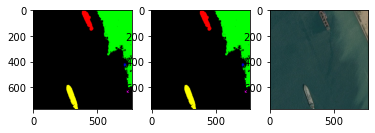

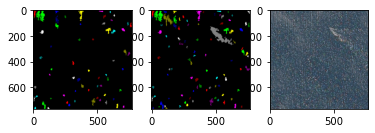

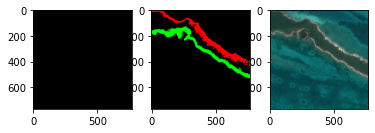

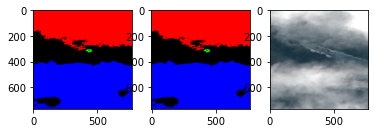

In [16]:
b_boxs = boats_box(b_boats)
b_boats_images = boats_as_image(b_boats, b_boxs)
b_boats = symetry_filter(b_boats, b_boats_images)
b_symetry = image(b_boats)

c_boxs = boats_box(c_boats)
c_boats_images = boats_as_image(c_boats, c_boxs)
c_boats = symetry_filter(c_boats, c_boats_images)
c_symetry = image(c_boats)

d_boxs = boats_box(d_boats)
d_boats_images = boats_as_image(d_boats, d_boxs)
d_boats = symetry_filter(d_boats, d_boats_images)
d_symetry = image(d_boats)

f_boxs = boats_box(f_boats)
f_boats_images = boats_as_image(f_boats, f_boxs)
f_boats = symetry_filter(f_boats, f_boats_images)
f_symetry = image(f_boats)


plt.subplot(1,3,1)
plt.imshow(b_symetry)
plt.subplot(1,3,2)
plt.imshow(b_e)
plt.subplot(1,3,3)
plt.imshow(b)
plt.show()

plt.subplot(1,3,1)
plt.imshow(c_symetry)
plt.subplot(1,3,2)
plt.imshow(c_e)
plt.subplot(1,3,3)
plt.imshow(c)
plt.show()

plt.subplot(1,3,1)
plt.imshow(d_symetry)
plt.subplot(1,3,2)
plt.imshow(d_e)
plt.subplot(1,3,3)
plt.imshow(d)
plt.show()

plt.subplot(1,3,1)
plt.imshow(f_symetry)
plt.subplot(1,3,2)
plt.imshow(f_e)
plt.subplot(1,3,3)
plt.imshow(f)
plt.show()

This method offers sometimes some results such as on the third image where it managed to detect that the lines were not ships, or on the noisy image (the second) where it reduces a bit the number of fragments. But generally, it isn't a really powerful method with in its current state (of code core and parameters).

### Orientation filter

The last filter tried and the most efficient, it works on an "orientation rosace" made from the distance of each pixel to the center average pixel. It then calculates the maximum of amount of pixels in a region and its position, and the maximum in the other hemisphere, there is a first condition on these two maximums. The second condition is placed on the angle between the axis of these two maximums that should not be too high. And the last condition is based on the fraction between these maximums and the side maximums that is supposed to be grand enough (a ship is generally longer than its width).

In [17]:
def slice_list(l, start, stop):
    '''
        Thif function is a utilitary for the orientation_filter.
        It returns the part of the l list between start and stop and the indices linked to these cases.
    '''
    lenght = len(l)
    
    if start > stop:
        if start >= lenght:
            return l[start%lenght:stop+1], [i for i in range(start%lenght, stop+1)]
        elif stop < -1:
            return l[start:stop+1], [i for i in range(start, len(l)+stop+1)]
        elif stop == -1:
            return l[start:], [i for i in range(start, len(l))]
        return l[start:] + l[:stop], [i for i in range(start, len(l))] + [i for i in range(stop)] # General situation
    
    else:
        if stop >= lenght:
            return l[start:] + l[:stop%lenght+1], [i for i in range(start, len(l))] + [i for i in range(stop%lenght+1)]
        elif start < 0:
            return l[start:] + l[:stop+1], [i for i in range(len(l)+start, len(l))] + [i for i in range(stop+1)]
        return l[start:stop+1], [i for i in range(start, stop+1)] # General stuation
    
def orientation_filter(boats, boats_images, relation_max = 2, interval_teta = 30, angle_check = 45, relation_size = 2):
    '''
        Another filter that works on the direction of the pixels of the image compary to a center pixel (the average of every ship pixels),
    it then check different conditions (maximum, agnle, thickness) to determiner if the amount of pixel is a ship or not.
        Parameters :
            - boats : the list each amounts of pixels on the image, each one are lists of Sections objects (see Encoding.py)
            - boats_images : the same boats under image form (result of the boats_as_image function)
            - relation_max : maxmimum fraction value between the two maximums (M1 and M2)
            - interval_teta : interval of acceptance for the angle between the second maximum and the first maximum's axis
            - angle_check : caracterise the width of the side regions (angle interval around each main maximum)
            - relation_size : minimal value of the relation between the main maximums and the side maximums for considering the "boat" as
        a ship
    '''
    
    to_del = [] # The boats to delete
    interval_teta *= 2*pi/360 # Degrees -> Radiant
    angle_check *= 2*pi/360 # Degrees -> Radiant
    # Let's compute the average position of the pixels of each boat
    for i in range(len(boats_images)):
        a, b = 0, 0
        count = 0    
        boat = boats_images[i]
        size = boat.shape
        
        for x in range(size[0]):
            for y in range(size[1]):
                if boat[x, y, 0] == 255: # Ship pixel
                    a += x ; b += y
                    count += 1            
        a /= count ; b /= count # Average computing
        
        # Let's calculate the angles between each pixel and the average pixel
        # We will categorise these pixels in 64 categories (angle intervals)
        angles_amount = [0 for j in range(64)] # Number of pixels in each interval        
        for x in range(size[0]):
            for y in range(size[1]):
                if boat[x, y, 0] == 255: # Ship pixel
                    teta = 0
                    # Calculating the angle between the (x, y) pixel and the (a, b) average pixel of the boat
                    if x > a:
                        teta = atan((y-b) / (x-a))
                    elif  x < a:
                        teta = pi + atan((y-b) / (x-a))
                    elif x == a and y > b:
                        teta = pi/2
                    elif x == a and y < b:
                        teta = 3*pi/2
                    # else : teta = 0
                    
                    pos = int(teta*63/(2*pi)) # Angle -> Position in the angles and angles_amount lists
                    angles_amount[pos] += 1 # +1 pixel to this interval of angles
        
        # We now get to the heart of the matter, we have to decide whether this amount of pixel is really a ship or not
        # Let's tak about the global strategy :
        #   - we start by finding a global maximum of angles_amount
        #   - we then look for the global maximum of the other hemisphere (well visible in polar view)
        #   - a first ship condition is placed on the size difference between these two maximums
        #   - we compute the angle between the second maximum and the axis of the first one, another condition is place on it
        #   - we finally check that the width is far thiner than the lenght (form of a ship) by looking at the maximum of angles_amount 
        # in the side zones
        M1 = angles_amount.index(max(angles_amount)) # Position of the maximum
        hem1, hem2 = int(M1 - 63/4), int(M1 + 63/4) # Borders of the hemisphere which include M1
        # We call the slice_list function that generates a list of the values of the other hemisphere (with there indices in angles_amount)
        sl = slice_list(angles_amount, hem2, hem1)
        M2 = sl[1][sl[0].index(max(sl[0]))] # The find the position of the maximum of this second hemisphere
        amount_M1, amount_M2 = angles_amount[M1], angles_amount[M2] # The values of these two maximums
        
        # First "no-ship" condition : a maximum in far smaller than the other
        if amount_M1/amount_M2 > relation_max:
            to_del.append(i)
        else:
            teta = pi*(abs(M2 - M1)*2/63 - 1) # The angle between M2 and the axis passing by M1 and the center
            # Second "no-ship" condition : this angle is too high, meaning that the ship is forming a strange angle...
            if teta < -interval_teta or teta > interval_teta:
                to_del.append(i)
            else:
                # We now look at the side regions (perpendicular to the main axis)
                # These regions are delimited by reg1 and reg2
                reg1, reg2 = int(M1 + 63*angle_check/(2*pi)), int(M2 - 63*angle_check/(2*pi))
                sl = slice_list(angles_amount, reg1, reg2)
                M3 = sl[1][sl[0].index(max(sl[0]))] # The position of the maximum of this first side region
                amount_M3 = angles_amount[M3] # The value of the maximum of this first side region
                
                reg1, reg2 = int(M2 + 63*angle_check/(2*pi)), int(M1 - 63*angle_check/(2*pi))
                sl = slice_list(angles_amount, reg1, reg2)
                M4 = sl[1][sl[0].index(max(sl[0]))] # Maximum if the other side region
                amount_M4 = angles_amount[M4]
                
                # The last "no-ship" condition : the relation between the lenght and the width is too high (not the form of a boat)
                if min(amount_M1, amount_M2)/max(amount_M3, amount_M4) < relation_size:
                    to_del.append(i)
         
        # Let's show angles_amount in polar coordinates
        #plt.figure()
        #angles = np.linspace(0, 2*pi, 64) 
        #plt.polar(angles, angles_amount)
        #M = [angles_amount[M1], 0, angles_amount[M2]] ; M_pos = [M1*2*pi/63, 0, M2*2*pi/63] # In order to visualise the maximums M1 and M2
        #plt.polar(M_pos, M)
            
    plt.show()
    
    return del_boats(boats, to_del)

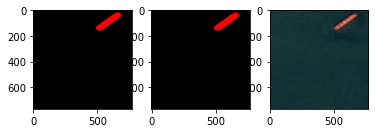

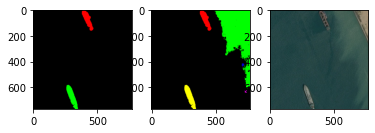

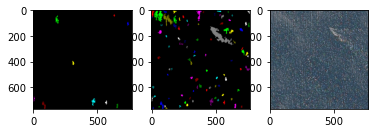

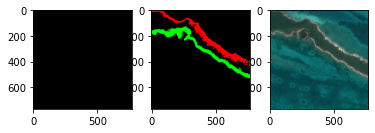

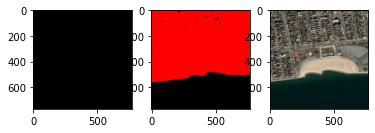

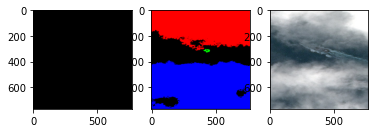

In [18]:
a_boxs = boats_box(a_boats)
a_boats_images = boats_as_image(a_boats, a_boxs)
a_boats = orientation_filter(a_boats, a_boats_images)
a_orientation = image(a_boats)

b_boxs = boats_box(b_boats)
b_boats_images = boats_as_image(b_boats, b_boxs)
b_boats = orientation_filter(b_boats, b_boats_images)
b_orientation = image(b_boats)

c_boxs = boats_box(c_boats)
c_boats_images = boats_as_image(c_boats, c_boxs)
c_boats = orientation_filter(c_boats, c_boats_images)
c_orientation = image(c_boats)

d_boxs = boats_box(d_boats)
d_boats_images = boats_as_image(d_boats, d_boxs)
d_boats = orientation_filter(d_boats, d_boats_images)
d_orientation = image(d_boats)

e_boxs = boats_box(e_boats)
e_boats_images = boats_as_image(e_boats, e_boxs)
e_boats = orientation_filter(e_boats, e_boats_images)
e_orientation = image(e_boats)

f_boxs = boats_box(f_boats)
f_boats_images = boats_as_image(f_boats, f_boxs)
f_boats = orientation_filter(f_boats, f_boats_images)
f_orientation = image(f_boats)


plt.subplot(1,3,1)
plt.imshow(a_orientation)
plt.subplot(1,3,2)
plt.imshow(a_e)
plt.subplot(1,3,3)
plt.imshow(a)
plt.show()

plt.subplot(1,3,1)
plt.imshow(b_orientation)
plt.subplot(1,3,2)
plt.imshow(b_e)
plt.subplot(1,3,3)
plt.imshow(b)
plt.show()

plt.subplot(1,3,1)
plt.imshow(c_orientation)
plt.subplot(1,3,2)
plt.imshow(c_e)
plt.subplot(1,3,3)
plt.imshow(c)
plt.show()

plt.subplot(1,3,1)
plt.imshow(d_orientation)
plt.subplot(1,3,2)
plt.imshow(d_e)
plt.subplot(1,3,3)
plt.imshow(d)
plt.show()

plt.subplot(1,3,1)
plt.imshow(e_orientation)
plt.subplot(1,3,2)
plt.imshow(e_e)
plt.subplot(1,3,3)
plt.imshow(e)
plt.show()

plt.subplot(1,3,1)
plt.imshow(f_orientation)
plt.subplot(1,3,2)
plt.imshow(f_e)
plt.subplot(1,3,3)
plt.imshow(f)
plt.show()

Here we can see that this method is the much efficient of the 3, especially when it comes to delete litorals and non-ship forms, the best example is the second image where the ships are truly recognised as ships and the littoral removed. It also manage to delete a lot of fragments in noisy images like the third one even if it is still not enough.
The main limit of this method is its incapacity to detect small ships : indeed, small ships are often of circular aspect due to the low resolution of the image and hist trail (that enlarges the boat in the detection). Sometimes, it even misses big ships... In conclusion, it is a rather good post-processing model but it still needs some improvments. 

But the efficiency of all these post-processing methods mainly rely on the quality of the upstream treatment which is of a medium quality in this case. If it was of better quality we could hope for even better results after post-processing.